## Silver analytics - social media

Fonte de dados: PostgreSQL (tabela silver.user)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import warnings

warnings.filterwarnings('ignore', category=UserWarning, message='.*SQLAlchemy.*')

In [3]:
DB_CONFIG = {
    'host': 'localhost',
    'port': 5433,
    'database': 'social_media',
    'user': 'postgres',
    'password': 'postgres'
}

conn = psycopg2.connect(**DB_CONFIG)

df_silver = pd.read_sql_query("""
    SELECT 
        user_id, age, gender, country, urban_rural, income_level, 
        employment_status, relationship_status, exercise_hours_per_week, 
        sleep_hours_per_night, diet_quality, smoking, alcohol_frequency, 
        perceived_stress_score, self_reported_happiness, body_mass_index, 
        blood_pressure_systolic, blood_pressure_diastolic, 
        daily_steps_count, weekly_work_hours, social_events_per_month, 
        books_read_per_year, volunteer_hours_per_month, 
        daily_active_minutes_instagram, reels_watched_per_day, 
        stories_viewed_per_day, ads_viewed_per_day, ads_clicked_per_day, 
        time_on_feed_per_day, time_on_explore_per_day, 
        time_on_reels_per_day, followers_count, following_count, 
        content_type_preference, preferred_content_theme, 
        user_engagement_score
    fROM silver.user """,conn)

print(f"✓ {len(df_silver):,} registros extraídos do PostgreSQL")

✓ 608,923 registros extraídos do PostgreSQL


## OBJETIVOS E REGRAS DE NEGÓCIO DO PROJETO

O projeto tem como objetivo analisar uma base de dados de usuários do instagram, como o foco principal na área de saúde ou seja, focamos principalmente nas colunas que teriam informações importantes para entender melhor a saúde dos nossos usuários, os dados foram tratados de acordo com a nossas regras de negócios tendo como produto final dashboards no power BI, com o intuito de mostrar padrões de usuários do instagram com a finalidade de dar uma audiência qualificada para empresas interessadas como planos de saúde, academia e outros serviços relacionados a saúde fisica dos usuarios, além disso alguns gráficos também possibilitarão empresas que querem vender seus produtos, como uma loja de tênis de corrida, por exemplo.

Como principal regras de negócios foi acordado que:
- Nosso projeto filtrou os países da base de dados, com isso o enfoque foi apenas nos países da América que estavam presentes na base, que são: Brasil, Canada e Estados Unidos;
- Para um público mais qualificado foi filtrado apenas para maiores de 18 anos;
- Foram retiradas as colunas que não seriam de valor para o projeto de 58 colunas iniciais restaram apenas 38. 
- Retirar os outliers da base de dados para uma melhor análise.

Cada gráfico que será mostrado abaixo também foi utilizada uma regra de negócio específica, que será falada na descrição do mesmo.

## 2 Gráficos relacionados a rede social

## 2.1 Porcentagem de usuários por país

Para saber onde devemos concentrar os investimentos de divulgação foi feito um gráfico com a porcentagem de usuários de cada pais.

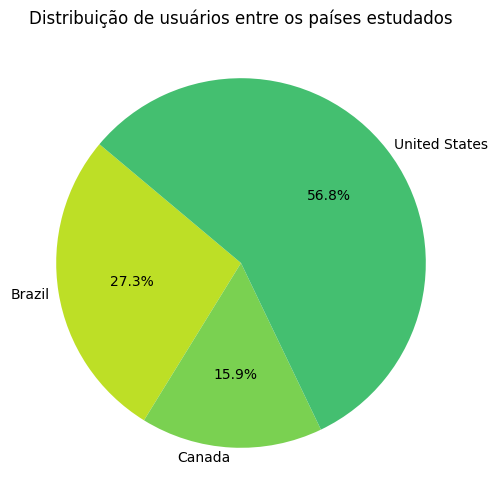

In [4]:
paises_count = df_silver.groupby('country').country.count()
plt.figure(figsize=(10,6))
plt.pie(paises_count, autopct='%1.1f%%', startangle=140,labels= paises_count.index,colors = plt.cm.viridis(np.linspace(0.9, 0, 10)), labeldistance=1.05)
plt.title('Distribuição de usuários entre os países estudados')
plt.show()

## 2.2 Faixa étaria de cada país

Para enteder melhor qual a faixa étaria maioria do público de cada pais, foram feitos histogramas da faixa etaria agrupadas por seu país.

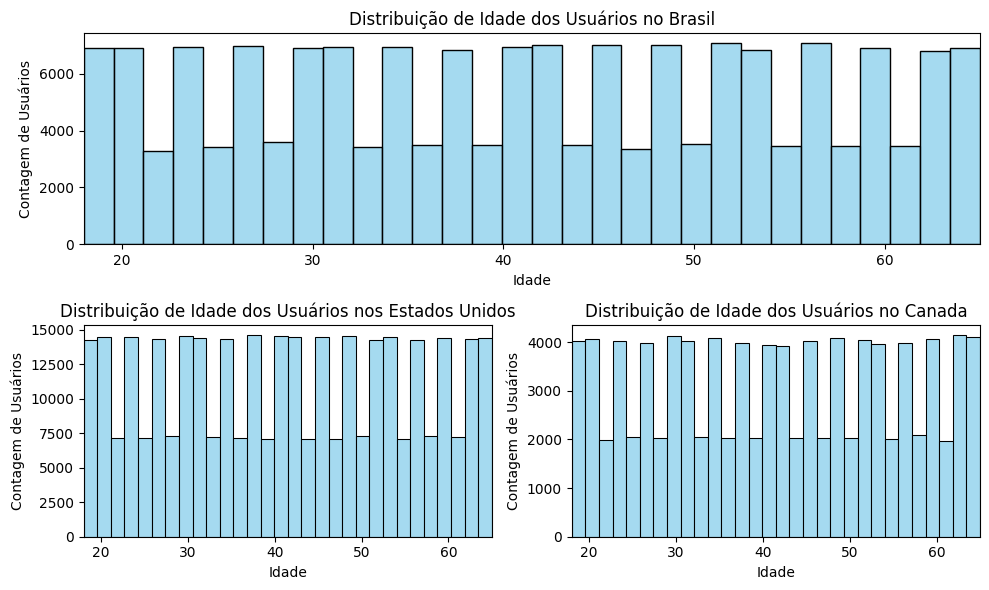

In [5]:
df_BR = df_silver[df_silver['country'] == 'Brazil']
df_EUA = df_silver[df_silver['country'] == 'United States']
df_CN = df_silver[df_silver['country'] == 'Canada']
idade_count = df_silver.groupby('age').age.count()
fig = plt.figure(figsize=(10,6))
grid = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(grid[0,:])
ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[1, 1])

grafBR = sns.histplot(data=df_BR, x='age',  color='skyblue',ax = ax1, bins=30)
grafBR.set_title('Distribuição de Idade dos Usuários no Brasil')
grafBR.set_xlabel('Idade')
grafBR.set_ylabel('Contagem de Usuários')
grafBR.set_xlim(18,65)

grafEUA = sns.histplot(data=df_EUA, x='age',  color='skyblue',ax = ax2, bins=30)
grafEUA.set_title('Distribuição de Idade dos Usuários nos Estados Unidos')
grafEUA.set_xlabel('Idade')
grafEUA.set_ylabel('Contagem de Usuários')
grafEUA.set_xlim(18,65)

grafCN = sns.histplot(data=df_CN, x='age',  color='skyblue',ax = ax3, bins=30)
grafCN.set_title('Distribuição de Idade dos Usuários no Canada')
grafCN.set_xlabel('Idade')
grafCN.set_ylabel('Contagem de Usuários')
grafCN.set_xlim(18,65)

plt.tight_layout()

## 2.3 Gráfico de cliques em anúncios, por faixa etaria 

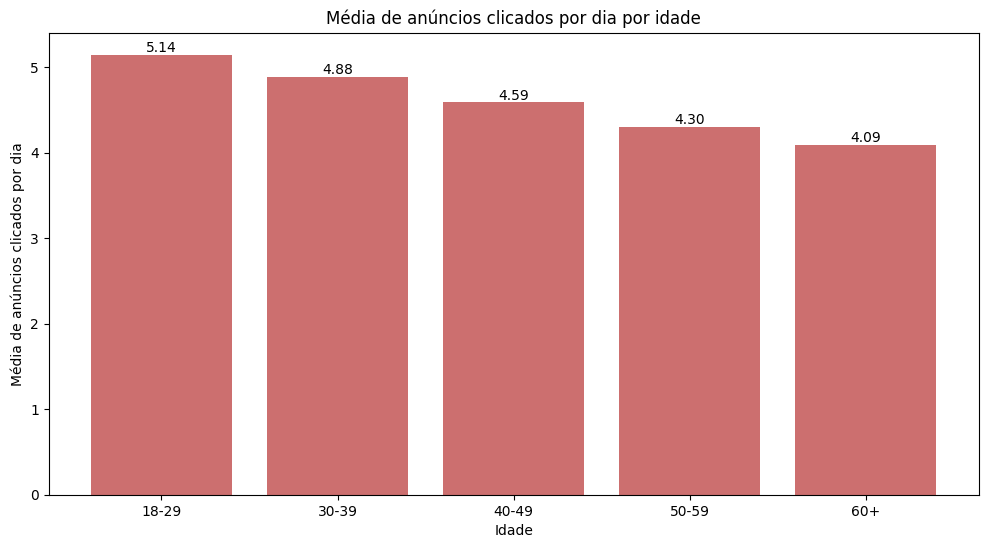

In [6]:
plt.figure(figsize=(12,6))

bins= [20,30,40,50,60,70]
labels = ['18-29','30-39','40-49','50-59','60+']

df_silver['age_group'] = pd.cut(df_silver['age'], bins=bins, labels=labels, right=False)

anum_id = df_silver.groupby('age_group', observed=True)['ads_clicked_per_day'].mean()
resul = plt.bar(anum_id.index, anum_id.values, color="#B73232", alpha=0.7)
for num in resul:
    height = num.get_height()
    plt.text(
        num.get_x() + num.get_width() / 2,
        height,
        f'{height:1.2f}',
        ha='center',
        va='bottom'
    )
plt.xlabel("Idade") 
plt.ylabel("Média de anúncios clicados por dia")
plt.title("Média de anúncios clicados por dia por idade")
plt.show()

Ao observar o gráfico, comparado com o mesmo feito na camada raw do projeto, pode ser observar que houve aumentos nas faixas etarias maiores de 40 anos e um diminuição nas faixas étarias menores,isso se deve porque os estudos do projeto se concentram em certos paises oque acabou causando essa variação nos cliques por idade.

## 2.4 Tipo de Conteudo mais consumido por cada Faixa étaria

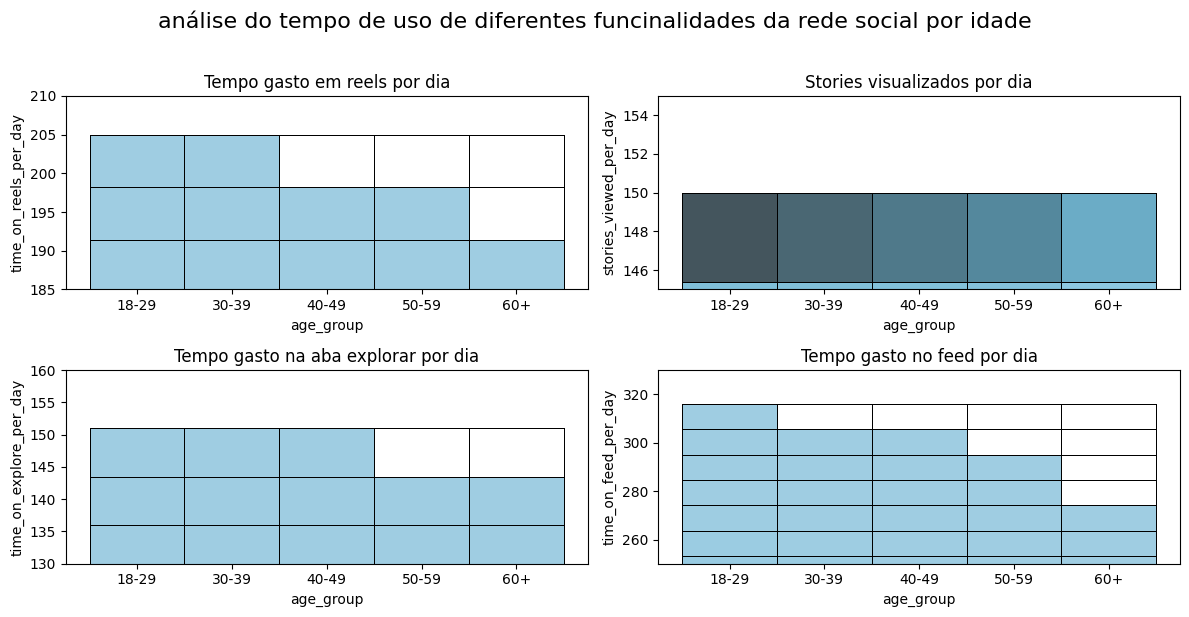

In [47]:
fig = plt.figure(figsize=(12,6))
grid = fig.add_gridspec(2,2)

binsv= [20,30,40,50,60,70]
labels = ['18-29','30-39','40-49','50-59','60+']

df_silver['age_group'] = pd.cut(df_silver['age'], bins=binsv, labels=labels, right=False)

ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[0,1])
ax3 = fig.add_subplot(grid[1,0])
ax4 = fig.add_subplot(grid[1,1])

graf1 = sns.histplot(x='age_group', y='time_on_reels_per_day', data=df_silver, kde=True, color='skyblue',ax = ax1,bins=30,edgecolor= 'black',linewidth=0.5)
graf2 = sns.histplot(x='age_group', y='stories_viewed_per_day', data=df_silver, kde=True, bins=30, color='skyblue',ax = ax2,edgecolor= 'black',linewidth=0.5)
graf3 = sns.histplot(x='age_group', y='time_on_explore_per_day', data=df_silver, kde=True, bins=20, color='skyblue',ax = ax3,edgecolor= 'black',linewidth=0.5)
graf4 = sns.histplot(x='age_group', y='time_on_feed_per_day', data=df_silver, kde=True, bins=30, color='skyblue',ax = ax4,edgecolor= 'black',linewidth=0.5)

graf1.set_ylim(185,210)
graf2.set_ylim(145,155)
graf3.set_ylim(130,160)
graf4.set_ylim(250,330)

graf1.set_title('Tempo gasto em reels por dia')
graf2.set_title('Stories visualizados por dia')
graf3.set_title('Tempo gasto na aba explorar por dia')
graf4.set_title('Tempo gasto no feed por dia')

fig.suptitle('análise do tempo de uso de diferentes funcinalidades da rede social por idade',fontsize=16, y=1.02,x=0.5 )
plt.tight_layout()

É possivel observar que, com a retirada de outliers e uma  especificação maior dos paises estudados houve uma padronização mais uma vez dos dados encontrados, oque pode-se concluir que os anuncios podem ser feitos em qualquer meio da rede social que eles terão possivelmente o mesmo resultado.

## 2.5 Quantidade de usuários interessados em conteudo fitness, por faixa étaria

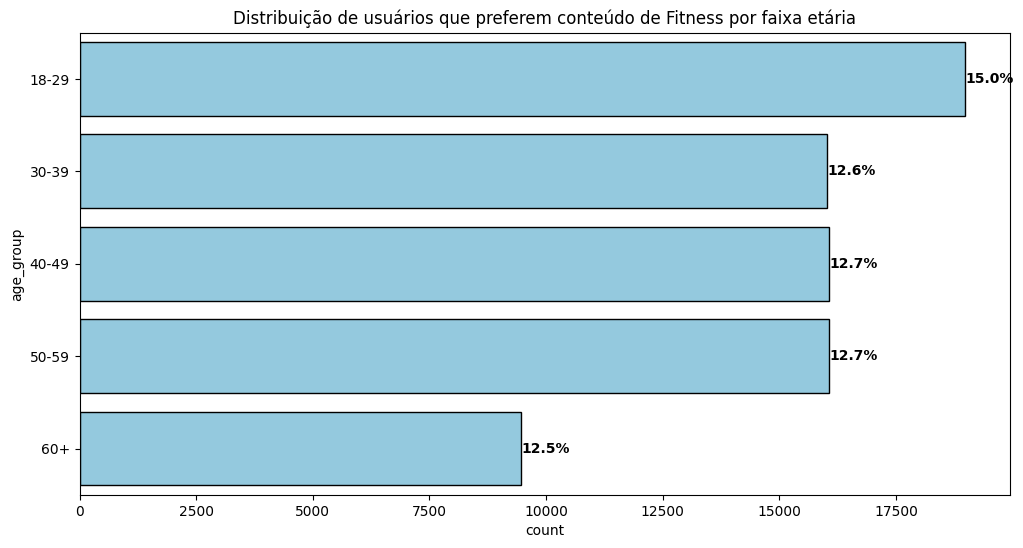

In [9]:
plt.figure(figsize=(12,6))
df_fit = df_silver[df_silver['preferred_content_theme'] == 'Fitness'].copy()

binsv = [18, 30, 40, 50, 60, 70]
labels = ['18-29', '30-39', '40-49', '50-59', '60+']
df_fit['age_group'] = pd.cut(df_fit['age'], bins=binsv, labels=labels, right=False)

contagem_fit = df_fit['age_group'].value_counts().sort_index()
contagem_total = df_silver['age_group'].value_counts().sort_index()
porcentagens = (contagem_fit / contagem_total) * 100

for i, label in enumerate(labels):
    qtd = contagem_fit[label]
    pct = porcentagens[label]
    plt.text(qtd + 5, i, f'{pct:.1f}%', va='center', fontsize=10, fontweight='bold')
    
sns.countplot(y='age_group', data=df_fit, color='skyblue', edgecolor='black', linewidth=1)
plt.title('Distribuição de usuários que preferem conteúdo de Fitness por faixa etária')

plt.show()

É possivel ver um grande interesse dos jovens no conteúdo fitness, oque pode indicar uma audiência qualificada para anúncios sobre o conteúdo fitness, como academias ou lojas de materiais esportivos.

## 2.6 Quantidade de usuários interessados em conteúdo fitness, por país.

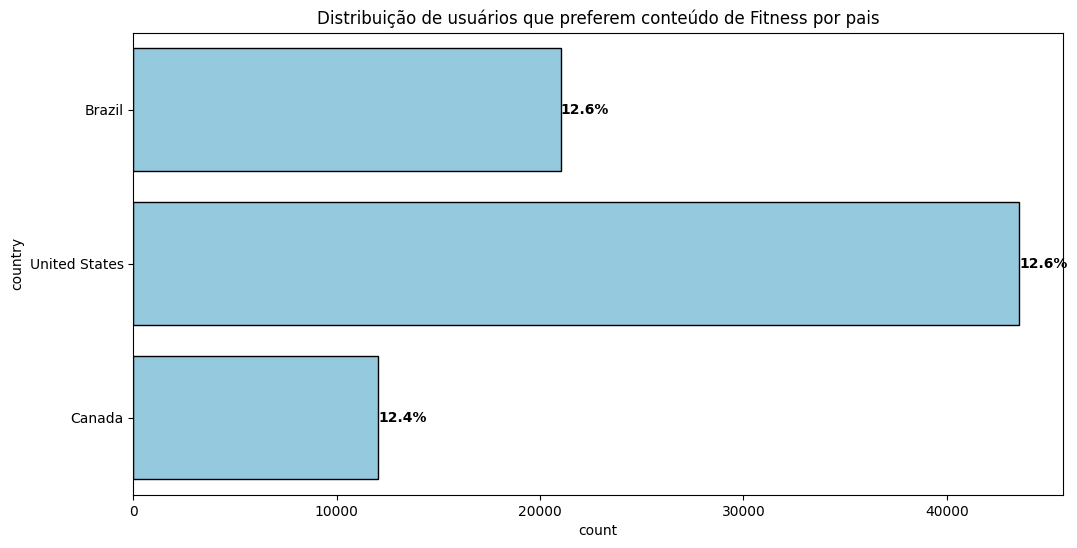

In [10]:
plt.figure(figsize=(12,6))
df_fit = df_silver[df_silver['preferred_content_theme'] == 'Fitness'].copy()

contagem_fit = df_fit['country'].value_counts().sort_index()
contagem_total = df_silver['country'].value_counts().sort_index()
porcentagens = (contagem_fit / contagem_total) * 100



ax = sns.countplot(y='country', data=df_fit, color='skyblue', edgecolor='black', linewidth=1)

paises_no_grafico = [label.get_text() for label in ax.get_yticklabels()]
for i, nome_pais in enumerate(paises_no_grafico):
    qtd = contagem_fit[nome_pais]
    pct = porcentagens[nome_pais]
    plt.text(qtd + 5,i  , f'{pct:.1f}%', va='center', fontsize=10, fontweight='bold')
plt.title('Distribuição de usuários que preferem conteúdo de Fitness por pais')

plt.show()

Por mais que a maioria tenha uma porcentagem de usuários que preferem esse tipo de conteúdo bem parecida, o país que mais se destaca é o Brasil oque pode indicar dele ser um bom alvo de publicidade sobre o assunto fit.

## 2.7 Paises que mais clicam em anuncios   

Afim de descobrir qual seria o país que mais teria usuários interessados em clicar em anúncios, foi feito um gráfico mostrando a relação de anúncios clicados pelo país do usuário

Text(0.5, 1.0, 'Média de anúncios clicados por dia por país')

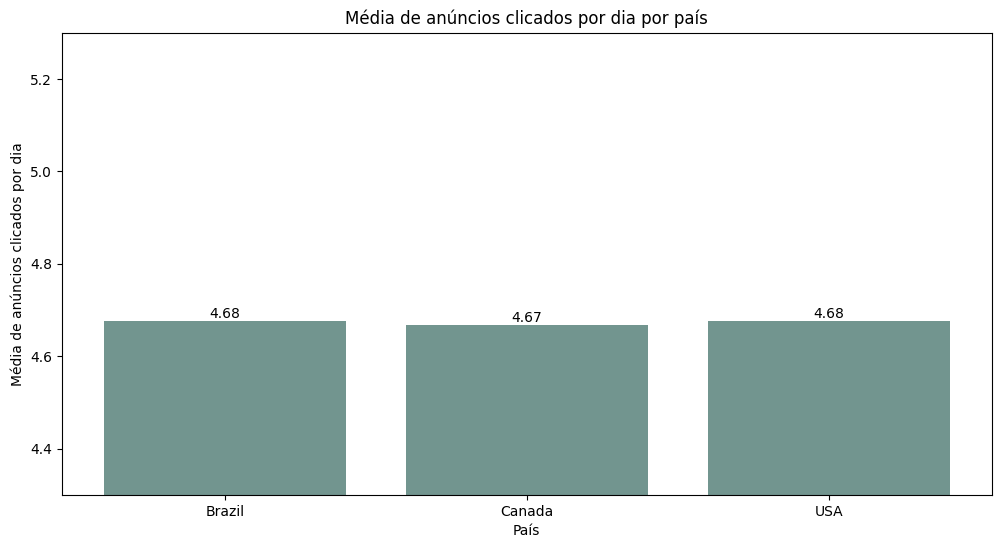

In [11]:
plt.figure(figsize=(12,6))
df_silver['country'] = df_silver['country'].replace({'United Kingdom': 'UK', 'United States': 'USA'})
anum_c = df_silver.groupby('country')['ads_clicked_per_day'].mean()
resul = plt.bar(anum_c.index, anum_c.values, color="#376860", alpha=0.7)
for num in resul:
    height = num.get_height()
    plt.text(
        num.get_x() + num.get_width() / 2,
        height,
        f'{height:1.2f}',
        ha='center',
        va='bottom'
    )
plt.ylim(4.3,5.3)
plt.xlabel("País") 
plt.ylabel("Média de anúncios clicados por dia")
plt.title("Média de anúncios clicados por dia por país")

É possivel perceber um certo padrão no numero de anúncios clicados por dia, oque pode-se concluir que todos os países onde for feita a divulgação de serviços e produtos relacionados a saúde fisica terão aproximadamente o mesmo desempenho. 
É possivel concluir tambem que, ao retirar os dados considerados outliers houve uma aumento do numeros de anuncios assistidos em todos os países.

## 3 Gráficos relacionados a saúde 

## 3.1 Relação de países que mais fumam
Gráfica mostra a distribuição de fumantes por país na base de dados. 

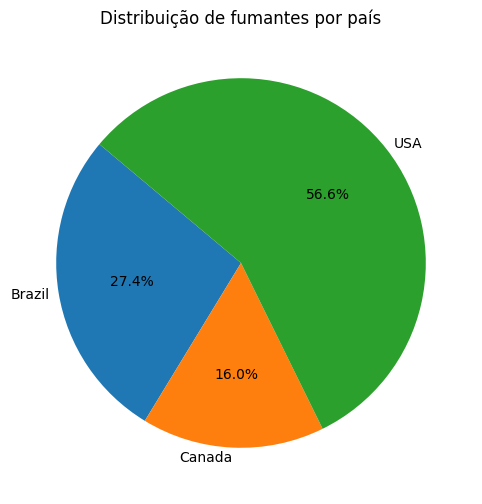

In [12]:
df_fumantes = df_silver[df_silver['smoking'] == 'Yes']

fumantes_paises = df_fumantes.groupby('country').country.count()

plt.figure(figsize=(10, 6))
plt.pie(
    fumantes_paises,
    autopct='%1.1f%%',
    startangle=140,
    labels=fumantes_paises.index,
    labeldistance=1.05
)
plt.title('Distribuição de fumantes por país')
plt.show()



Comparando com o Analytcs da raw, agora, com apenas 3 países o Estados Unidos se agiganta ainda mais na porcentagem, antes era de apenas 25%. Brasil antes era de 12,1 % e Canada 7,1%. 

## 3.2 Fumantes por faixa etária
Gráfico abaixo mostra a quantidade de fumantes por faixa etária na base de dados.

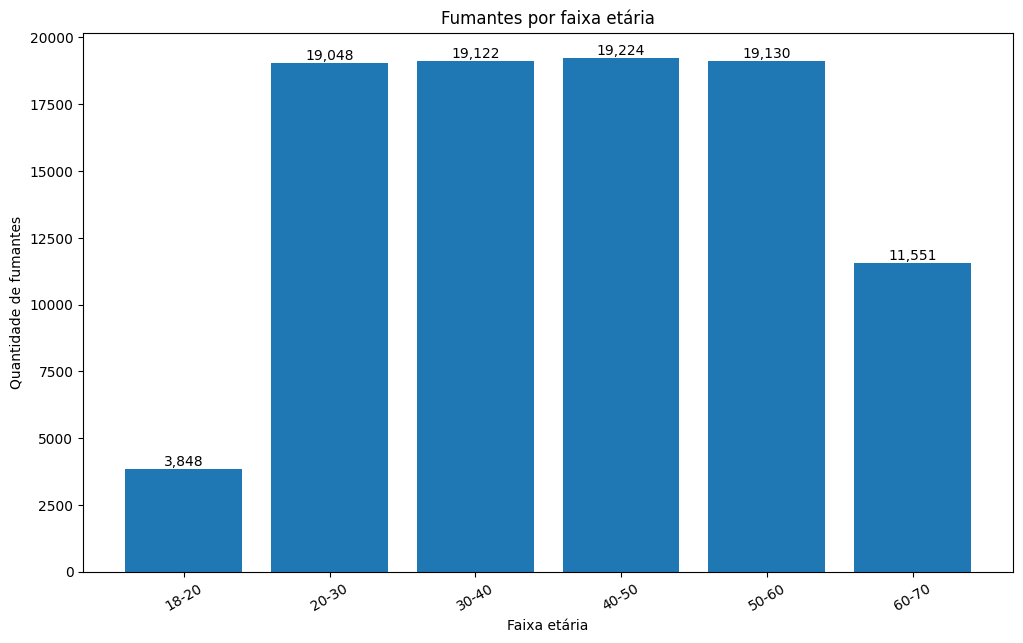

In [13]:
bins = [18, 20, 30, 40, 50, 60, 90]
labels = ['18-20', '20-30', '30-40', '40-50', '50-60', '60-70']

df_fumantes = df_silver.loc[df_silver['smoking'].str.lower() == 'yes'].copy()

df_fumantes['faixa_etaria'] = pd.cut(
    df_fumantes['age'],
    bins=bins,
    labels=labels,
    right=False
)

fumantes_idade = df_fumantes['faixa_etaria'].value_counts().sort_index()

plt.figure(figsize=(12, 7))
bars = plt.bar(fumantes_idade.index, fumantes_idade.values)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:,}',
        ha='center',
        va='bottom'
    )

plt.title('Fumantes por faixa etária')
plt.xlabel('Faixa etária')
plt.ylabel('Quantidade de fumantes')
plt.xticks(rotation=30)
plt.show()



Comparando com o Analytcs da anterior o padrão continua o mesmo, onde entre 20 e 60 são as idades com mais quantidades de fumantes, mas agora com uma mudança, com a retirada dos menores de 18 anos abaixou bastante a primeira barra, antes ela era superior ao pessoas de 60 anos.

## 3.3 Relação entre os países da américa e a quantidade de fumantes por idade
Gráfico mostra a relação ente os países da américa e a quantidade de fumantes por idade em cada um deles.

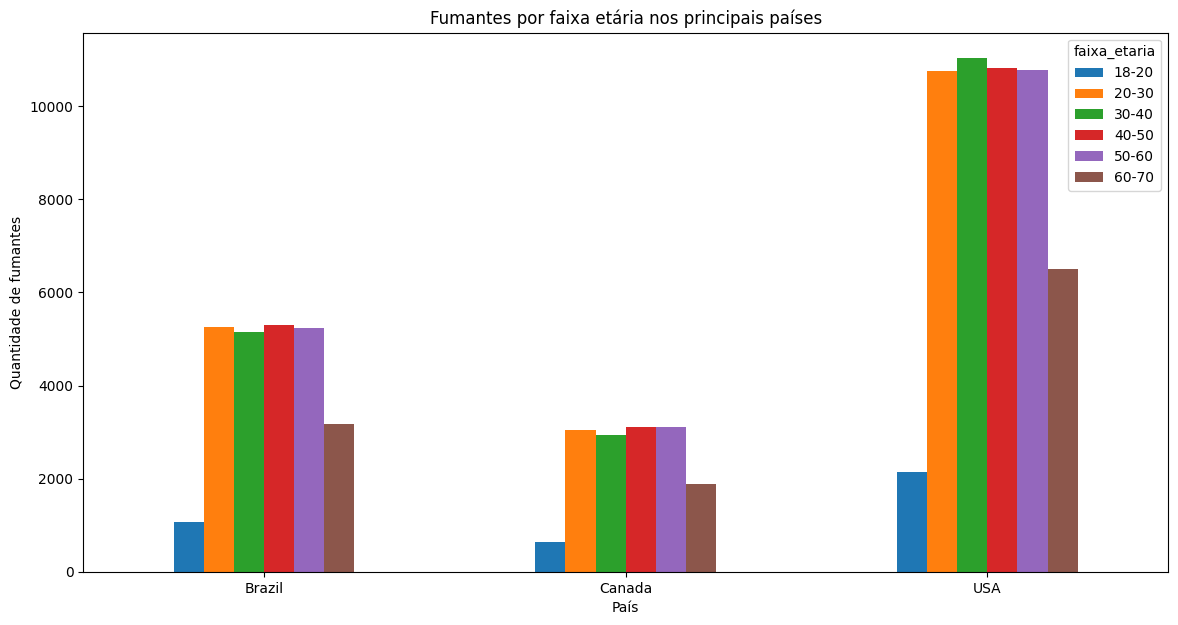

In [14]:
df_fumantes_sem_other = df_fumantes[df_fumantes['country'] != 'Other']

top_paises = (
    df_fumantes_sem_other['country']
    .value_counts()
    .head(5)
    .index
)

df_top = df_fumantes_sem_other[
    df_fumantes_sem_other['country'].isin(top_paises)
]

tabela_top = pd.crosstab(df_top['country'], df_top['faixa_etaria'])

tabela_top.plot(kind='bar', figsize=(14, 7))
plt.title('Fumantes por faixa etária nos principais países')
plt.xlabel('País')
plt.ylabel('Quantidade de fumantes')
plt.xticks(rotation=0)
plt.show()

Com a retirada dos Outliers e dos menores de 18 anos, é perceptível a diferença na quantidade de fumantes por cada idade, que agora é bem menor se for comparar com o gráfico da raw.

## 3.4 Classificação de risco dinâmico
Gráfico mostra uma matriz de correlação que tem como objetivo observar a relação de quantidade de exercício por semana com a idade e se a pessoa fuma ou não.<br>
Sendo de grande valia para gerar uma audiência qualificada para seguradoras ou planos de saúde, que podem aumentar o valor do plano, por exemplo.

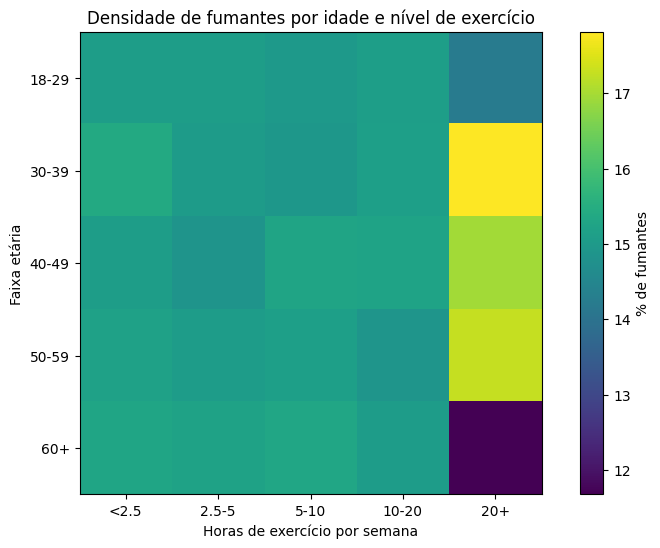

In [15]:
bins_ex = [0, 2.5, 5, 10, 20, 100]
labels_ex = ['<2.5', '2.5-5', '5-10', '10-20', '20+']

df_silver['faixa_exercicio'] = pd.cut(
    df_silver['exercise_hours_per_week'],
    bins=bins_ex,
    labels=labels_ex,
    right=False
)

bins_age = [18, 30, 40, 50, 60, 100]
labels_age = ['18-29', '30-39', '40-49', '50-59', '60+']

df_silver['faixa_idade'] = pd.cut(
    df_silver['age'],
    bins=bins_age,
    labels=labels_age,
    right=False
)

tabela = pd.crosstab(
    df_silver['faixa_idade'],
    df_silver['faixa_exercicio'],
    values=(df_silver['smoking'].str.lower() == 'yes'),
    aggfunc='mean'
) * 100

plt.figure(figsize=(10, 6))
plt.imshow(tabela)
plt.colorbar(label='% de fumantes')
plt.xticks(range(len(tabela.columns)), tabela.columns)
plt.yticks(range(len(tabela.index)), tabela.index)
plt.title('Densidade de fumantes por idade e nível de exercício')
plt.xlabel('Horas de exercício por semana')
plt.ylabel('Faixa etária')
plt.show()

Comparando com o mesmo gráfico só que com todos os países, a diferença é grande, mas uma coisa continua parecida, os usuários com mais de 60 anos e que fazem menos de 2,5 horas de exercício por dia são os que tem a maior porcentagem de fumantes.

## 3.5 Gráfico de pessoas de ALTO RISCO 
Gráfico de grande valor para seguradoras e planos de saúde, a regra utilizada aqui foi: pessoas que estão em risco elevado, ou seja, fumam e praticam menos de 5 horas de exercício por semana.<br>


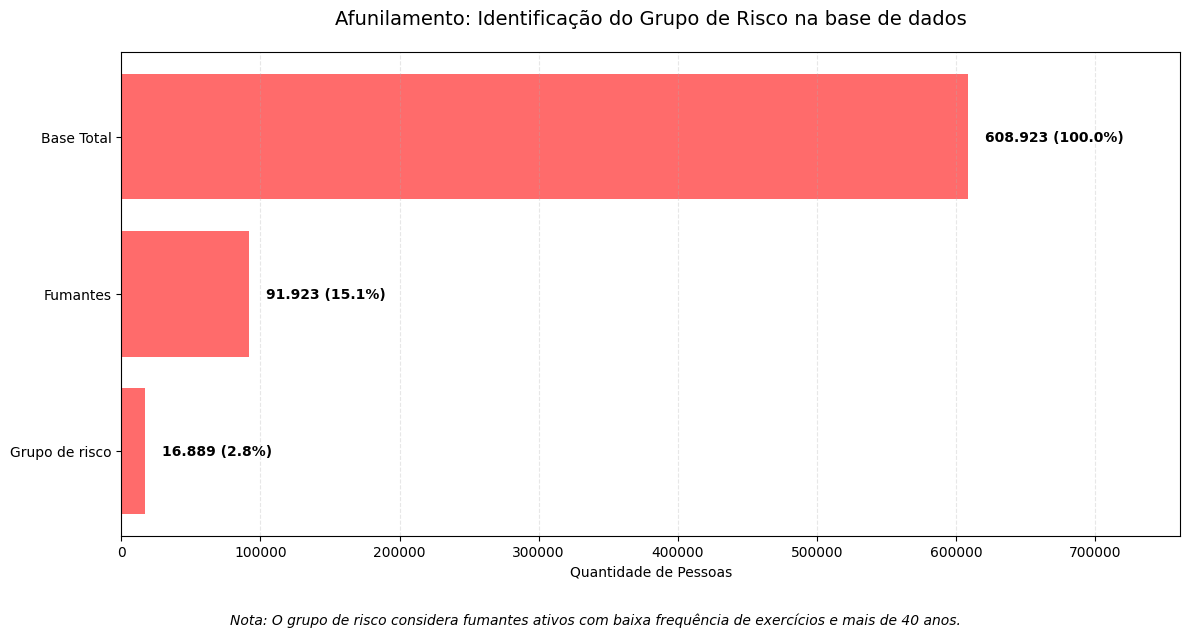

In [16]:
total_base = len(df_silver)

df_fumantes = df_silver[df_silver['smoking'].str.lower() == 'yes']
total_fumantes = len(df_fumantes)

df_grupo_risco = df_silver[(df_silver['age'] >= 40) & (df_silver['smoking'].str.lower() == 'yes') & (df_silver['exercise_hours_per_week'] < 5)]
total_grupo_risco = len(df_grupo_risco)

etapas = ["Base Total", "Fumantes", "Grupo de risco"]
valores = [total_base, total_fumantes, total_grupo_risco]

plt.figure(figsize=(12, 6))

bars = plt.barh(etapas[::-1], valores[::-1], color='#ff6b6b') 
for index, value in enumerate(valores[::-1]):
    percentual = (value / total_base) * 100
    plt.text(value + (max(valores) * 0.02), index, 
             f"{value:,} ({percentual:.1f}%)".replace(',', '.'), 
             va='center', fontweight='bold')

plt.xlim(0, max(valores) * 1.25) # o número tava encostando na barrinha final, aumenta o limite

plt.title('Afunilamento: Identificação do Grupo de Risco na base de dados', pad=20, fontsize=14)
plt.xlabel('Quantidade de Pessoas')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.figtext(0.5, -0.05, 
            "Nota: O grupo de risco considera fumantes ativos com baixa frequência de exercícios e mais de 40 anos.", 
            ha="center", fontsize=10, style='italic')
plt.tight_layout()
plt.show()





Aqui mesmo com a diminuição do país a porcentagem se manteve muito parecida na de fumantes e do grupo de risco, antes de 15% a de fumantes e 2,5% na de grupo de risco. 

## 3.6 Usuários com risco cardiovascular no mundo
Gráfico mostra as pessoas com risco cardiovascular no mundo, a regra utilizada foi de pessoas que tem 140 ou mais de pressão sistólica e 90 ou mais de diastólica ou o IMC é maior que 30.

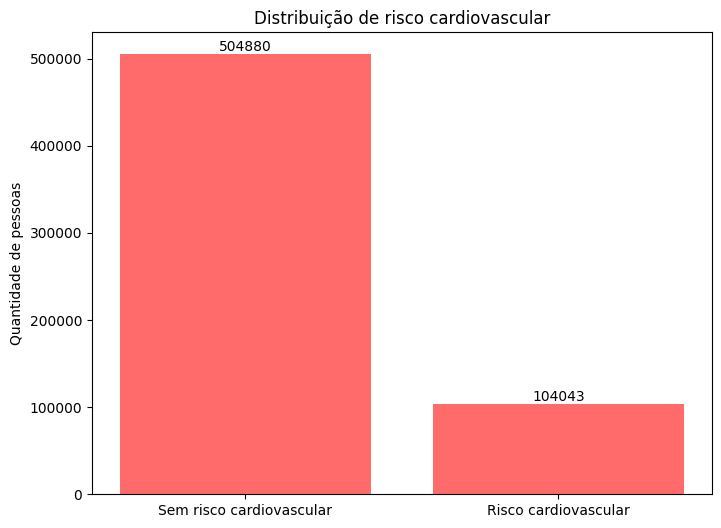

In [17]:
df = df_silver.copy()

condicao_risco = (
    (df['blood_pressure_systolic'] >= 140) &
    (df['blood_pressure_diastolic'] >= 90) |
    (df['body_mass_index'] >= 30)
)

df['grupo_cv'] = 'Sem risco cardiovascular'
df.loc[condicao_risco, 'grupo_cv'] = 'Risco cardiovascular'

contagem = df['grupo_cv'].value_counts()

plt.figure(figsize=(8,6))
bars = plt.bar(contagem.index, contagem.values, color = '#ff6b6b')

plt.title('Distribuição de risco cardiovascular')
plt.ylabel('Quantidade de pessoas')

for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f'{int(bar.get_height())}',
        ha='center',
        va='bottom'
    )

plt.show()

O gráfico mostra a quantidade de pessoas que possuem risco cardiovascular na nossa base de dados, podendo ser de grande interesse para planos de saúde ou seguradoras, até mesmo para área de academias para fazer anúncios tentando melhorar a qualidade de vidas dessas pessoas.

## 3.7 Análise do público esportivo nos países da América
Foi considerado público esportivo usuários que treinam 6 ou mais horas por dia e que não fumam.


In [18]:
publico_esportivo = df_silver[
    (df_silver['exercise_hours_per_week'] >= 6) &
    (df_silver['smoking'].str.lower() == 'no') 
].copy()

print(f'Tamanho do público esportivo: {len(publico_esportivo)} pessoas')

Tamanho do público esportivo: 256683 pessoas


Quantidade do público esportivo, audiência qualificada para academias, lojas de suplementos e de venda de artigos esportivos.

### 3.8 Gráfico que mostra a faixa etária desse público esportivo

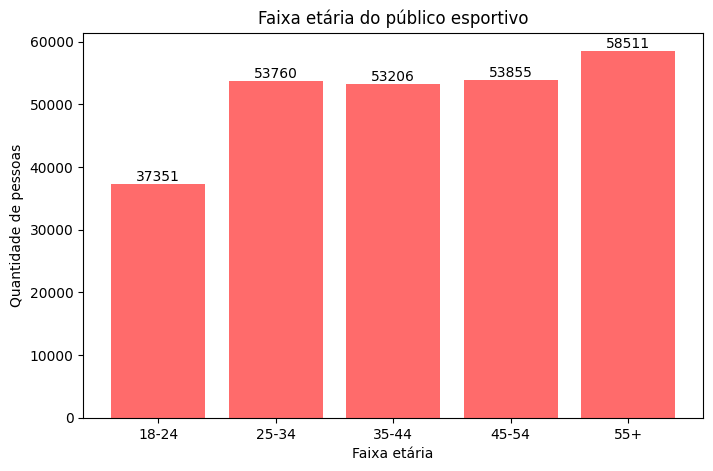

In [19]:
publico_esportivo['faixa_idade'] = pd.cut(
    publico_esportivo['age'],
    bins=[18, 25, 35, 45, 55, 100],
    labels=['18-24', '25-34', '35-44', '45-54', '55+'],
    right=False
)

contagem = publico_esportivo['faixa_idade'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
bars = plt.bar(contagem.index, contagem.values, color = '#ff6b6b')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )

plt.title('Faixa etária do público esportivo')
plt.xlabel('Faixa etária')
plt.ylabel('Quantidade de pessoas')
plt.show()

Analisando esse gráfico em comparação com o anterior, percebe-se que a maior parte continua parecida em comparação com as outras faixa etárias, apenas a primeira faixa etária de 18-24 que se destoa, agora considerando apenas maiores de 18 anos. Sendo de grande importância para marcas fitness saber em qual faixa etária tem o maior público que eles possam investir.

## 3.9 Media de exercicio fisico por faixa etaria

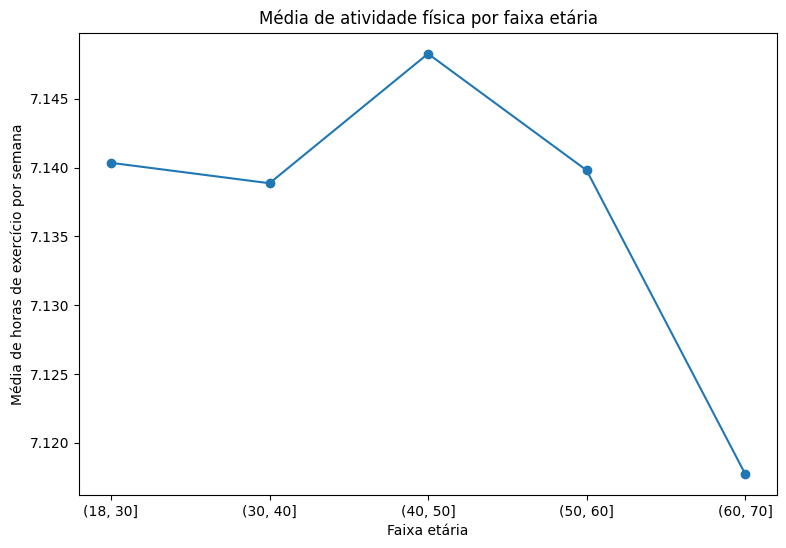

In [20]:
df_silver['faixa_idade'] = pd.cut(
    df_silver['age'],
    bins=[18, 30, 40, 50, 60, 70, 100]
)

media = df_silver.groupby(
    'faixa_idade',
    observed=True
)['exercise_hours_per_week'].mean()

plt.figure(figsize=(9,6))
plt.plot(media.index.astype(str), media.values, marker='o')

plt.xlabel('Faixa etária')
plt.ylabel('Média de horas de exercício por semana')
plt.title('Média de atividade física por faixa etária')

plt.show()

Ao observar o grafico, pode-se perceber que a faixa étaria que mais se destacou como a que mais pratica exercicio fisico é publico entre 40 a 50 anos, isso ocorre devido a serem pessoas com mais tempo livre para praticar atividades fisicas, pode-se observar tambem que o grafico como um todo houve uma redução de 0,1 horas de exercicio, isso se deve a retirada de outliers que puxavam o grafico para cima e tambem o enfoque maior nos paises das americas que aparentam ter pessoas que fazem menos exercicios fisicos que as de outros continentes. 

Ao observar esse grafico pode-se concluir que o melhor publico para as publicidades de exercicios fisicos e relacionados seria o publico  40+ devido a sua alta taxa de exercicio fisico na semana.

## 3.10 Relação de sendentarismo por faixa étaria 

Para ter uma ideia melhor da porcentagem do publico sedentario, faremos um grafico de barras com porcentagem de sedentarios a fim de descobrir se nosso possivel publico alvo (20 a 40 anos) tem uma margem de sedentarios muito alta, oque poderia ser ruim para nosso projeto

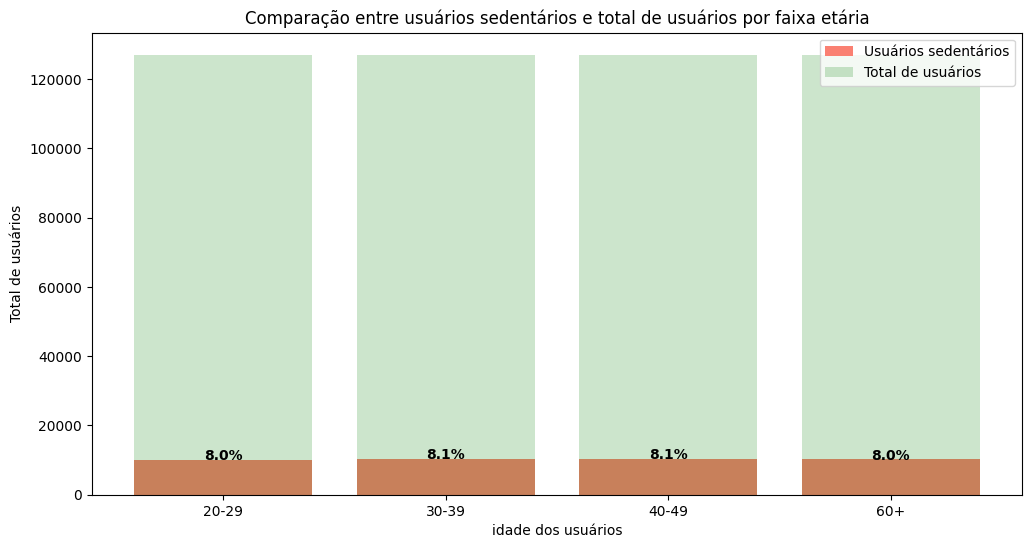

In [21]:
plt.figure(figsize=(12,6))

binsv= [20,30,40,50,60,]
labels = ['20-29','30-39','40-49','60+']

df_silver['age_group'] = pd.cut(df_silver['age'], bins=binsv, labels=labels, right=False)

df_silver['seden'] = df_silver['exercise_hours_per_week'] <= 2
df_silver['seden_total'] = df_silver[df_silver['seden'] == True]['exercise_hours_per_week']
idd_seden = df_silver.groupby('age_group',observed=True)['seden_total'].count() 
per = (idd_seden / df_silver.groupby('age_group',observed=True)['exercise_hours_per_week'].count()) * 100
plt.bar(idd_seden.index, idd_seden.values, color='salmon')
idd_total = df_silver.groupby('age_group',observed=True)['exercise_hours_per_week'].count()
plt.bar(idd_total.index, idd_total.values, color='green', alpha=0.2)
for i, valor_percentual in enumerate(per):
    plt.text(i, idd_seden.values[i] + 1, f'{valor_percentual:.1f}%', 
             ha='center', fontsize=10, fontweight='bold')
plt.xlabel("idade dos usuários") 
plt.ylabel("Total de usuários")
plt.title("Comparação entre usuários sedentários e total de usuários por faixa etária")
plt.legend(['Usuários sedentários', 'Total de usuários'])
plt.show()

Incrivelmente, a porcentagem de sedentarios é quase a mesma para todos os grupos de idades oque é parece ser um cenario ideal para nosso projeto, uma baixa taxa de sedentarismo entre os usuarios.

## 3.11 Sedentarismo entre os países estudados

Afim de descobrir qual pais poderia possivelmente se interessar menos por anuncios de exercicio fisico, foi feito um grafico a respeito do sedentarismo entre os usuarios agrupado por seu pais de origem.

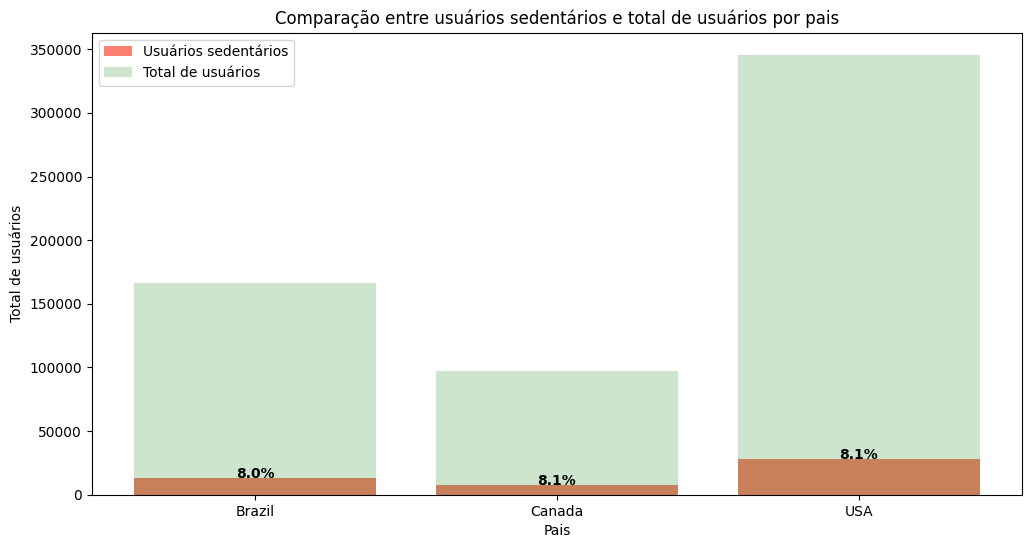

In [22]:
plt.figure(figsize=(12,6))



df_silver['seden'] = df_silver['exercise_hours_per_week'] <= 2
df_silver['seden_total'] = df_silver[df_silver['seden'] == True]['exercise_hours_per_week']
idd_seden = df_silver.groupby('country',observed=True)['seden_total'].count() 
per = (idd_seden / df_silver.groupby('country',observed=True)['exercise_hours_per_week'].count()) * 100
plt.bar(idd_seden.index, idd_seden.values, color='salmon')
idd_total = df_silver.groupby('country',observed=True)['exercise_hours_per_week'].count()
plt.bar(idd_total.index, idd_total.values, color='green', alpha=0.2)
for i, valor_percentual in enumerate(per):
    plt.text(i, idd_seden.values[i] + 1, f'{valor_percentual:.1f}%', 
             ha='center', fontsize=10, fontweight='bold')
plt.xlabel("Pais") 
plt.ylabel("Total de usuários")
plt.title("Comparação entre usuários sedentários e total de usuários por pais")
plt.legend(['Usuários sedentários', 'Total de usuários'])
plt.show()

É possivel perceber que tambem há um padrão entre paises, com numeros baixos de sedentarios.